# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Getting-Mean-Imputed-Temperature" data-toc-modified-id="Getting-Mean-Imputed-Temperature-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Getting Mean Imputed Temperature</a></div><div class="lev1 toc-item"><a href="#Nearby-Predictions" data-toc-modified-id="Nearby-Predictions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Nearby Predictions</a></div><div class="lev1 toc-item"><a href="#Obtaining-log-likelihoods" data-toc-modified-id="Obtaining-log-likelihoods-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Obtaining log-likelihoods</a></div>

In [1]:
const SAVED_DIR = "/Volumes/Samsung250GB/temperature_model/saved"

"/Volumes/Samsung250GB/temperature_model/saved"

In [2]:
using TimeSeries
using DataFrames
using GaussianProcesses
using GaussianProcesses: Mean, Kernel, evaluate, metric, IsotropicData, VecF64
using GaussianProcesses: Stationary, KernelData, MatF64, predict
import GaussianProcesses: optimize!, get_optim_target, cov, grad_slice!
import GaussianProcesses: num_params, set_params!, get_params, update_mll!, update_mll_and_dmll!
import GaussianProcesses: get_param_names, cov!, addcov!, multcov!
import Proj4
import Mamba
using JLD
using Distances
using DataFrames: by, head
using Dates: tonext, Hour, Day

In [3]:
include("src/TempModel.jl")

TempModel

In [4]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(12,8))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=false)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [5]:
isdList=TempModel.read_isdList()
isdSubset=isdList[[(usaf in (725450,725460,725480,725485)) for usaf in isdList[:USAF].values],:]
isdSubset

,USAF,WBAN,NAME,CTRY,STATE,ICAO,LAT,LON,ELEV,BEGIN,END,X_PRJ,Y_PRJ
1,725450,14990,THE EASTERN IOWA AIRPORT,US,IA,KCID,41.883,-91.717,264.6,1973,2015,1.64799e6,1.0441e6
2,725460,14933,DES MOINES INTERNATIONAL AIRPORT,US,IA,KDSM,41.534,-93.653,291.7,1973,2015,1.48723e6,1.00379e6
3,725480,94910,WATERLOO MUNICIPAL AIRPORT,US,IA,KALO,42.554,-92.401,264.6,1960,2015,1.59025e6,1.11766e6
4,725485,14940,MASON CITY MUNICIPAL ARPT,US,IA,KMCW,43.154,-93.327,373.4,1973,2015,1.51407e6,1.18374e6


In [6]:
hourly_cat=TempModel.read_Stations(isdSubset)
itest=3
hourly_train = hourly_cat[hourly_cat[:station].values.!=itest,:]
hourly_test  = hourly_cat[hourly_cat[:station].values.==itest,:]
nrow(hourly_train), nrow(hourly_test)
test_usaf=get(isdSubset[itest,:USAF])

725480

In [7]:
function subset(df, from, to; closed_start=true, closed_end=true)
    ts = df[:ts].values
    return df[argsubset(ts,from,to;closed_start=closed_start,closed_end=closed_end),:]
end
function argsubset(ts, from, to; closed_start=true, closed_end=true)
    if closed_start
        after_from = ts .>= from
    else
        after_from = ts .> from
    end
    if closed_end
        before_to = ts .<= to
    else
        before_to = ts .< to
    end
    return after_from & before_to
end

argsubset (generic function with 1 method)

In [9]:
type FittingWindow
    start_date::Date
    end_date::Date
end

In [10]:
function predictions_fname(usaf::Int, fw::FittingWindow)
    return @sprintf("%d_%s_to_%s.jld", 
                    usaf, fw.start_date, fw.end_date)
end

function get_nearby(fw::FittingWindow, GPmodel::AbstractString)
    saved_dir = joinpath(SAVED_DIR, "predictions_from_nearby", GPmodel)
    pred_fname = predictions_fname(test_usaf, fw)
    nearby_pred=load(joinpath(saved_dir, pred_fname))["nearby_pred"]
end

get_nearby (generic function with 1 method)

In [11]:
function stan_dirname(usaf::Int, fw::FittingWindow)
    return @sprintf("%d_%s_to_%s/", 
                    usaf, fw.start_date, fw.end_date)
end

stan_dirname (generic function with 1 method)

In [12]:
stan_increment = Day(3)
stan_days = Day(9)
janfirst = Date(2015,1,1)
;

In [13]:
function get_test_fw(test::DataFrame, fw::FittingWindow)
    window_start = DateTime(fw.start_date) + hr_measure
    window_end = DateTime(fw.end_date) + hr_measure
    return subset(test, window_start, window_end; closed_start=false)
end
function arg_test_fw(test::DataFrame, fw::FittingWindow)
    window_start = DateTime(fw.start_date) + hr_measure
    window_end = DateTime(fw.end_date) + hr_measure
    return argsubset(test[:ts].values, window_start, window_end; closed_start=false)
end
function get_window(windownum::Int)
    stan_start = janfirst + (windownum-1)*stan_increment
    stan_end = stan_start + stan_days
    stan_fw = FittingWindow(stan_start, stan_end)
    return stan_fw
end
function window_center(fw::FittingWindow, increment::Day)
    # this doesn't generalize
    return FittingWindow(fw.start_date+increment,fw.end_date-increment-Day(1))
end

window_center (generic function with 1 method)

In [14]:
function get_chains_and_ts(fw::FittingWindow, GPmodel::AbstractString, hr_measure_fals::Hour)
    stan_fw_dir = stan_dirname(test_usaf, fw)
    stan_model_dir = joinpath(SAVED_DIR,"hr_measure", GPmodel, string(Int(hr_measure_fals)))
    stan_window_files = readdir(joinpath(stan_model_dir, stan_fw_dir))
    samplefiles = [joinpath(stan_model_dir, stan_fw_dir, f) for 
        f in stan_window_files if 
        (startswith(f,"imputation_samples") &
        endswith(f,".csv"))]
    header=String[]
    all_samples=[]
    for sf in samplefiles
        samples, header = readcsv(sf, Float64; header=true)
        push!(all_samples, samples)
    end

    samples = cat(3, all_samples...)
    chains = Mamba.Chains(samples; start=1, thin=1, chains=[i for i in 1:4], names=vec(header))
    
    ts_string = readcsv(joinpath(stan_model_dir, stan_fw_dir, "timestamps.csv"), String; header=false)
    ts = [DateTime(s, "yyyy-mm-ddTHH:MM:SS") for s in vec(ts_string)]
    return chains, ts
end

get_chains_and_ts (generic function with 1 method)

In [15]:
# convenience function to extract the imputed temperatures
# from the Mamba Chains object
function get_temperatures_reparam(chains::Mamba.Chains)
    temp_varnames = [h for h in chains.names if startswith(h, "temp_impt.")]
    temp_samples=getindex(chains, :, temp_varnames, :).value
    return temp_samples
end

get_temperatures_reparam (generic function with 1 method)

In [16]:
function get_temp_percentiles(temp_impute)
    stacked_impute=vcat((temp_impute[:,:,i] for i in 1:size(temp_impute,3))...)
    sorted_impute = sort(stacked_impute,1);
    nsamples=size(sorted_impute,1)
    # extract  10th and 90th percentiles
    # of the imputations
    imputed_10 = sorted_impute[div(nsamples,10), :]
    imputed_90 = sorted_impute[nsamples-div(nsamples,10), :]
    return imputed_10, imputed_90
end
function get_temp_mean(temp_impute)
    stacked_impute=vcat((temp_impute[:,:,i] for i in 1:size(temp_impute,3))...)
    μ = vec(mean(stacked_impute, 1))
    return μ
end

get_temp_mean (generic function with 1 method)

In [17]:
function plot_imputations(ts, temp_impute)
    imputed_10, imputed_90 = get_temp_percentiles(temp_impute)
    μ = get_temp_mean(temp_impute)
    
    plt.fill_between(ts, imputed_10, imputed_90, 
        color="#F16424", alpha=0.5, label=L"$80\%$ credible interval")
    plt.plot(ts, temp_impute[250,:,1],
        color="#009F77", label="single imputation")
    plt.plot(ts, μ, color="#F16424", linewidth=3, label="posterior mean")
end
function plot_truth(test::DataFrame)
    ts = test[:ts].values
    plt.plot(ts, test[:temp].values, 
        color="black", "o-", label="true hourly")
    plt.plot(ts, test_subsubset[:Tn].values, 
        color="blue", linewidth=3, label=L"$T_n$")
    plt.plot(ts, test_subsubset[:Tx].values, 
        color="red", linewidth=3, label=L"$T_x$")
end

plot_truth (generic function with 1 method)

# Getting Mean Imputed Temperature

In [114]:
stitched_ts_dict = Dict{Hour,Vector{DateTime}}()
stitched_mean_dict = Dict{Hour,Vector{Float64}}()

@time for hr in (Hour(5),Hour(17))
    stitched_ts_dict[hr] = DateTime[]
    stitched_mean_dict[hr] = Float64[]
    println("hour: ", hr)
    for window_num in 1:119
        local chains
        local ts
        println("\twindownum: ", window_num)
        stan_fw = get_window(window_num)
        center_fw = window_center(stan_fw, stan_increment)
        GPmodel = "SExSE"
        try
            chains, ts = get_chains_and_ts(stan_fw, GPmodel, hr);
        catch
            break
        end

        temp_impute = get_temperatures_reparam(chains)
        arg_center_fw = [(center_fw.start_date <= TempModel.measurement_date(t, hr) <= center_fw.end_date)
            for t in ts]
        temp_impute_center = temp_impute[:,arg_center_fw,:]
        mean_imputation = vec(mean(temp_impute_center, (1,3)))
        @assert length(mean_imputation)==sum(arg_center_fw)
        @assert length(ts[arg_center_fw])==sum(arg_center_fw)
        append!(stitched_ts_dict[hr], ts[arg_center_fw])
        append!(stitched_mean_dict[hr], mean_imputation)
    end
end

hour: 5 hours
	windownum: 1
	windownum: 2
	windownum: 3
	windownum: 4
	windownum: 5
	windownum: 6
	windownum: 7
	windownum: 8
	windownum: 9
	windownum: 10
	windownum: 11
	windownum: 12
	windownum: 13
	windownum: 14
	windownum: 15
	windownum: 16
	windownum: 17
	windownum: 18
	windownum: 19
	windownum: 20
	windownum: 21
	windownum: 22
	windownum: 23
	windownum: 24
	windownum: 25
	windownum: 26
	windownum: 27
	windownum: 28
	windownum: 29
	windownum: 30
	windownum: 31
	windownum: 32
	windownum: 33
	windownum: 34
	windownum: 35
	windownum: 36
	windownum: 37
	windownum: 38
	windownum: 39
	windownum: 40
	windownum: 41
	windownum: 42
	windownum: 43
	windownum: 44
	windownum: 45
	windownum: 46
	windownum: 47
	windownum: 48
	windownum: 49
	windownum: 50
	windownum: 51
	windownum: 52
	windownum: 53
	windownum: 54
	windownum: 55
	windownum: 56
	windownum: 57
	windownum: 58
	windownum: 59
	windownum: 60
	windownum: 61
	windownum: 62
	windownum: 63
	windownum: 64
	windownum: 65
	windownum: 66
	wind

In [127]:
overlap = [maximum(minimum(ts) for ts in values(stitched_ts_dict)), 
           minimum(maximum(ts) for ts in values(stitched_ts_dict))]
overlap_imput_dict = Dict{Hour,Vector{Float64}}()
global overlap_ts
for hr in keys(stitched_mean_dict)
    overlap_ind = argsubset(stitched_ts_dict[hr], overlap[1], overlap[2], closed_start=true, closed_end=true)
    overlap_imput = stitched_mean_dict[hr][overlap_ind]
    overlap_imput_dict[hr] = overlap_imput
    overlap_ts = stitched_ts_dict[hr][overlap_ind]
end

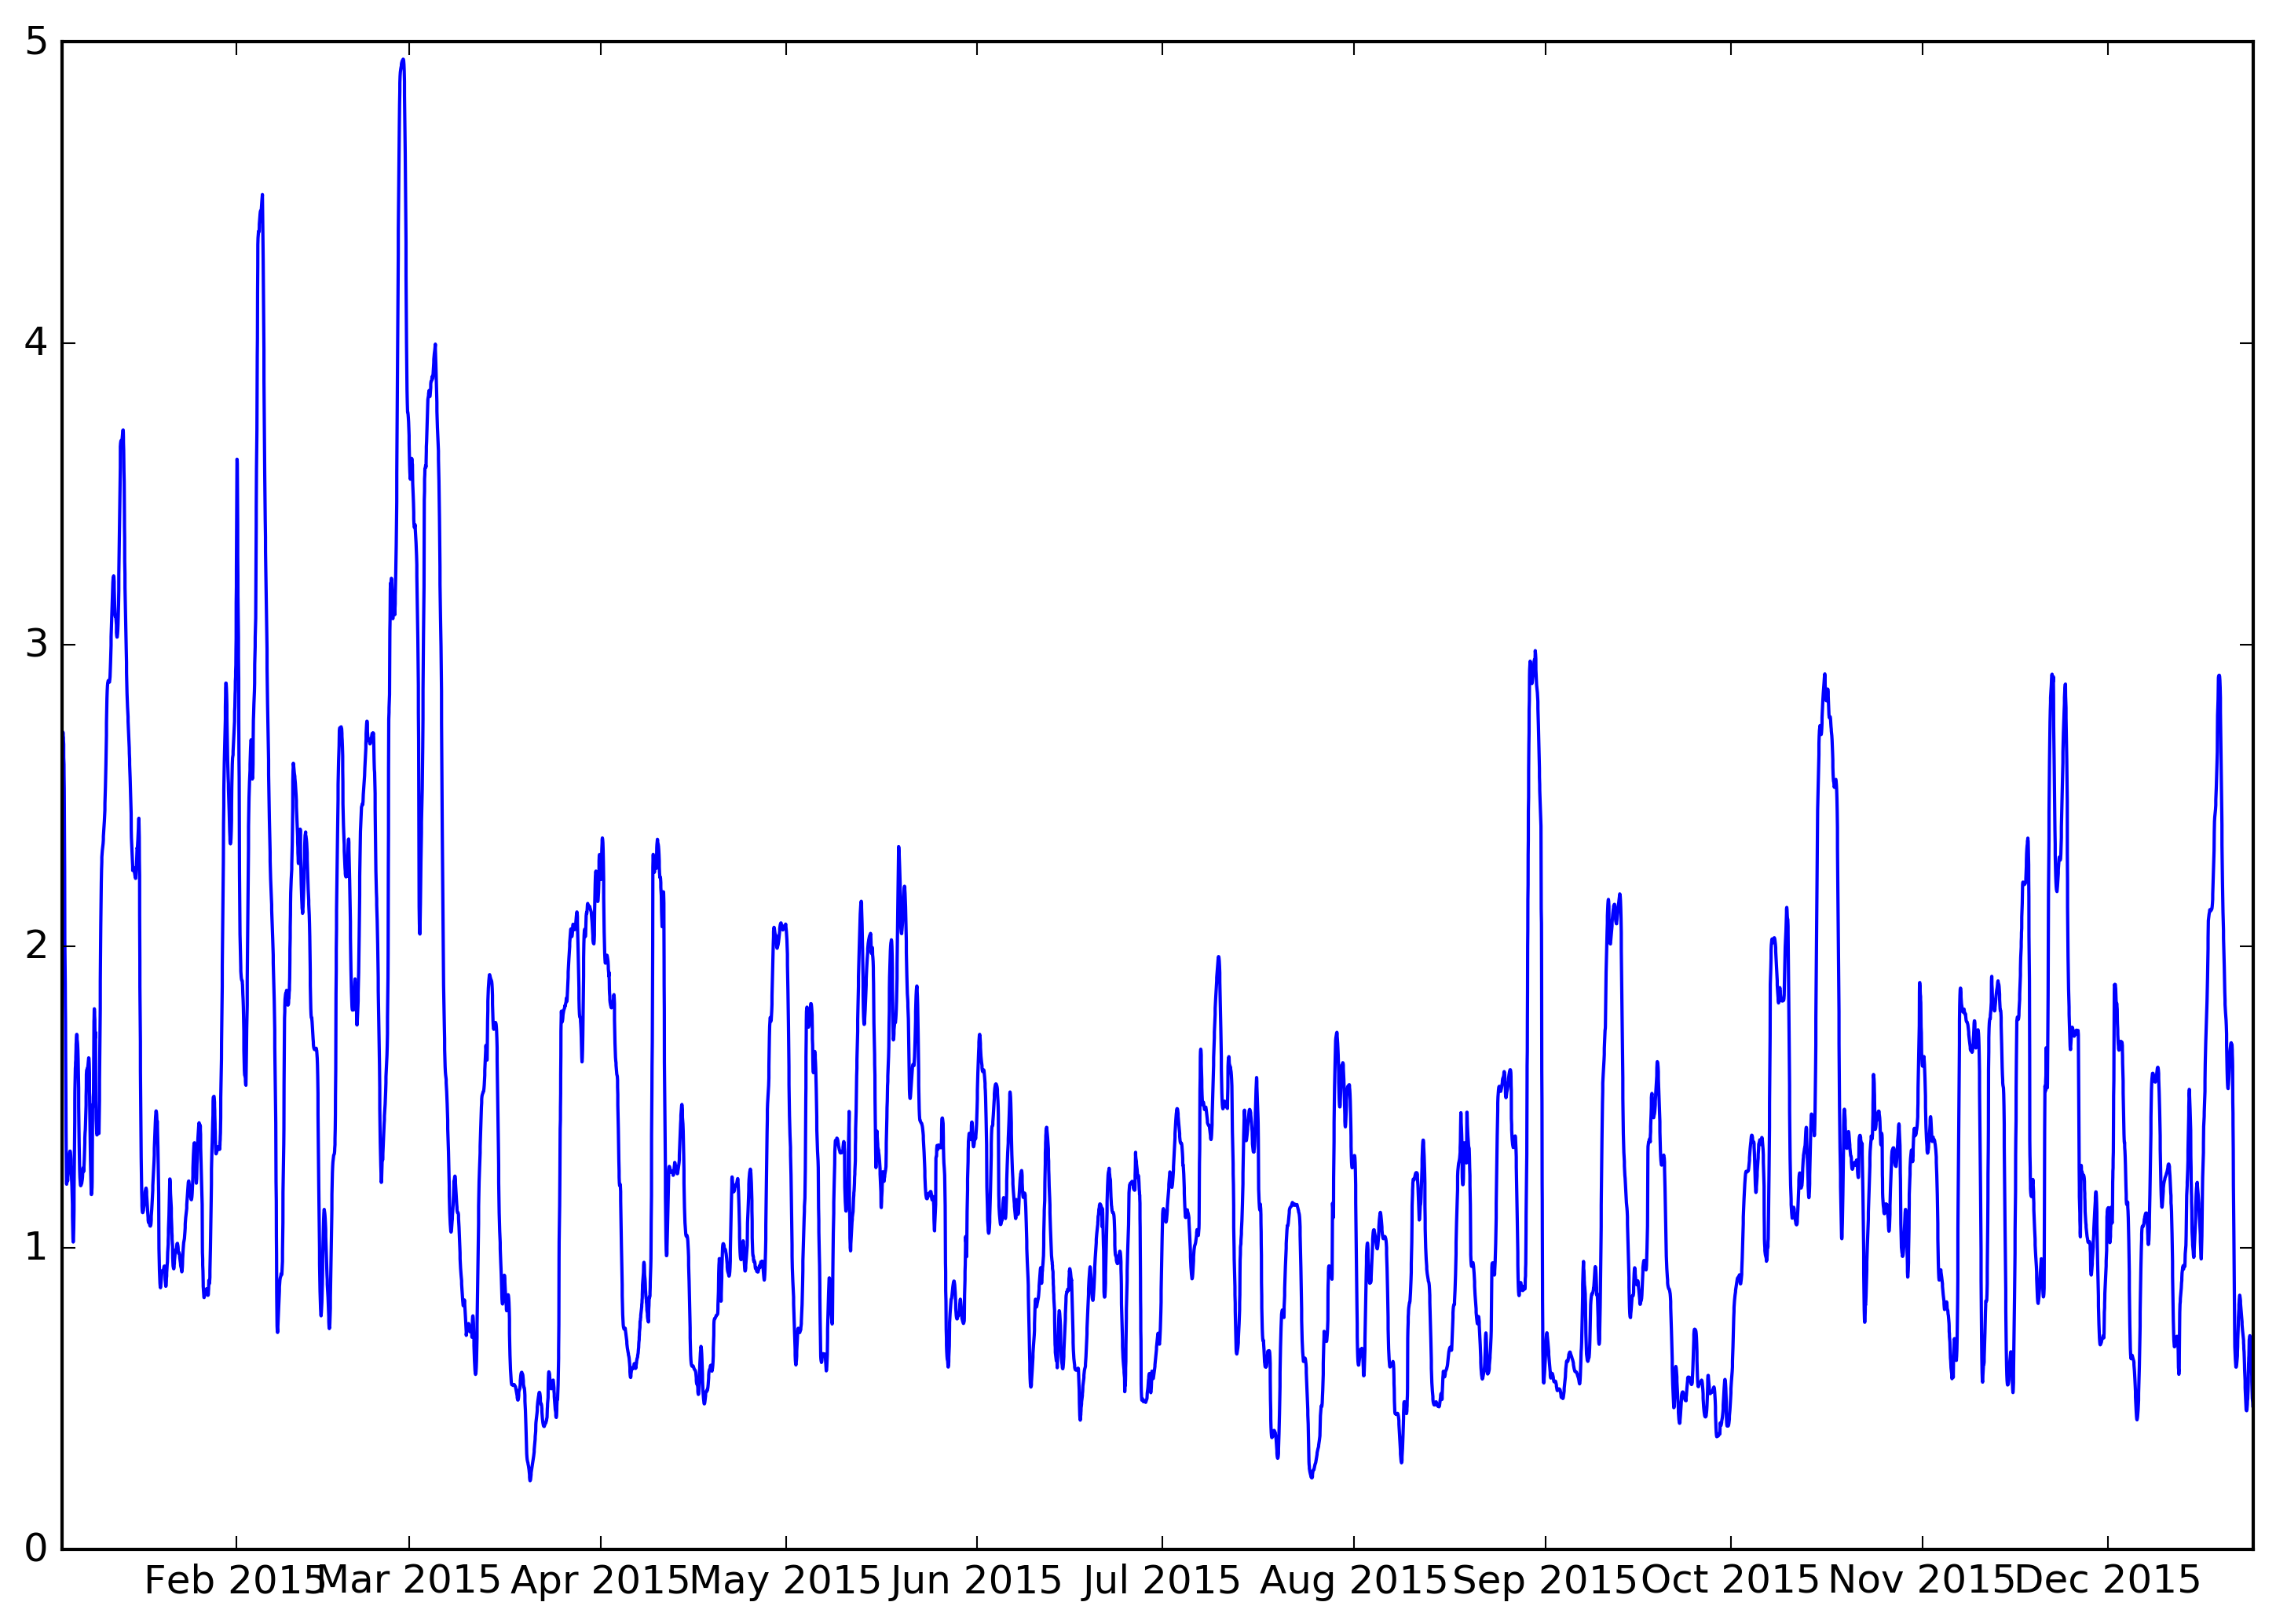

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3849212d0>

In [128]:
diff_imput = abs(overlap_imput_dict[Hour(17)].-overlap_imput_dict[Hour(5)])
smoothed_diff = [mean(diff_imput[i:i+100]) for i in 1:length(diff_imput)-100]
plt.plot(overlap_ts[1:end-100],smoothed_diff)

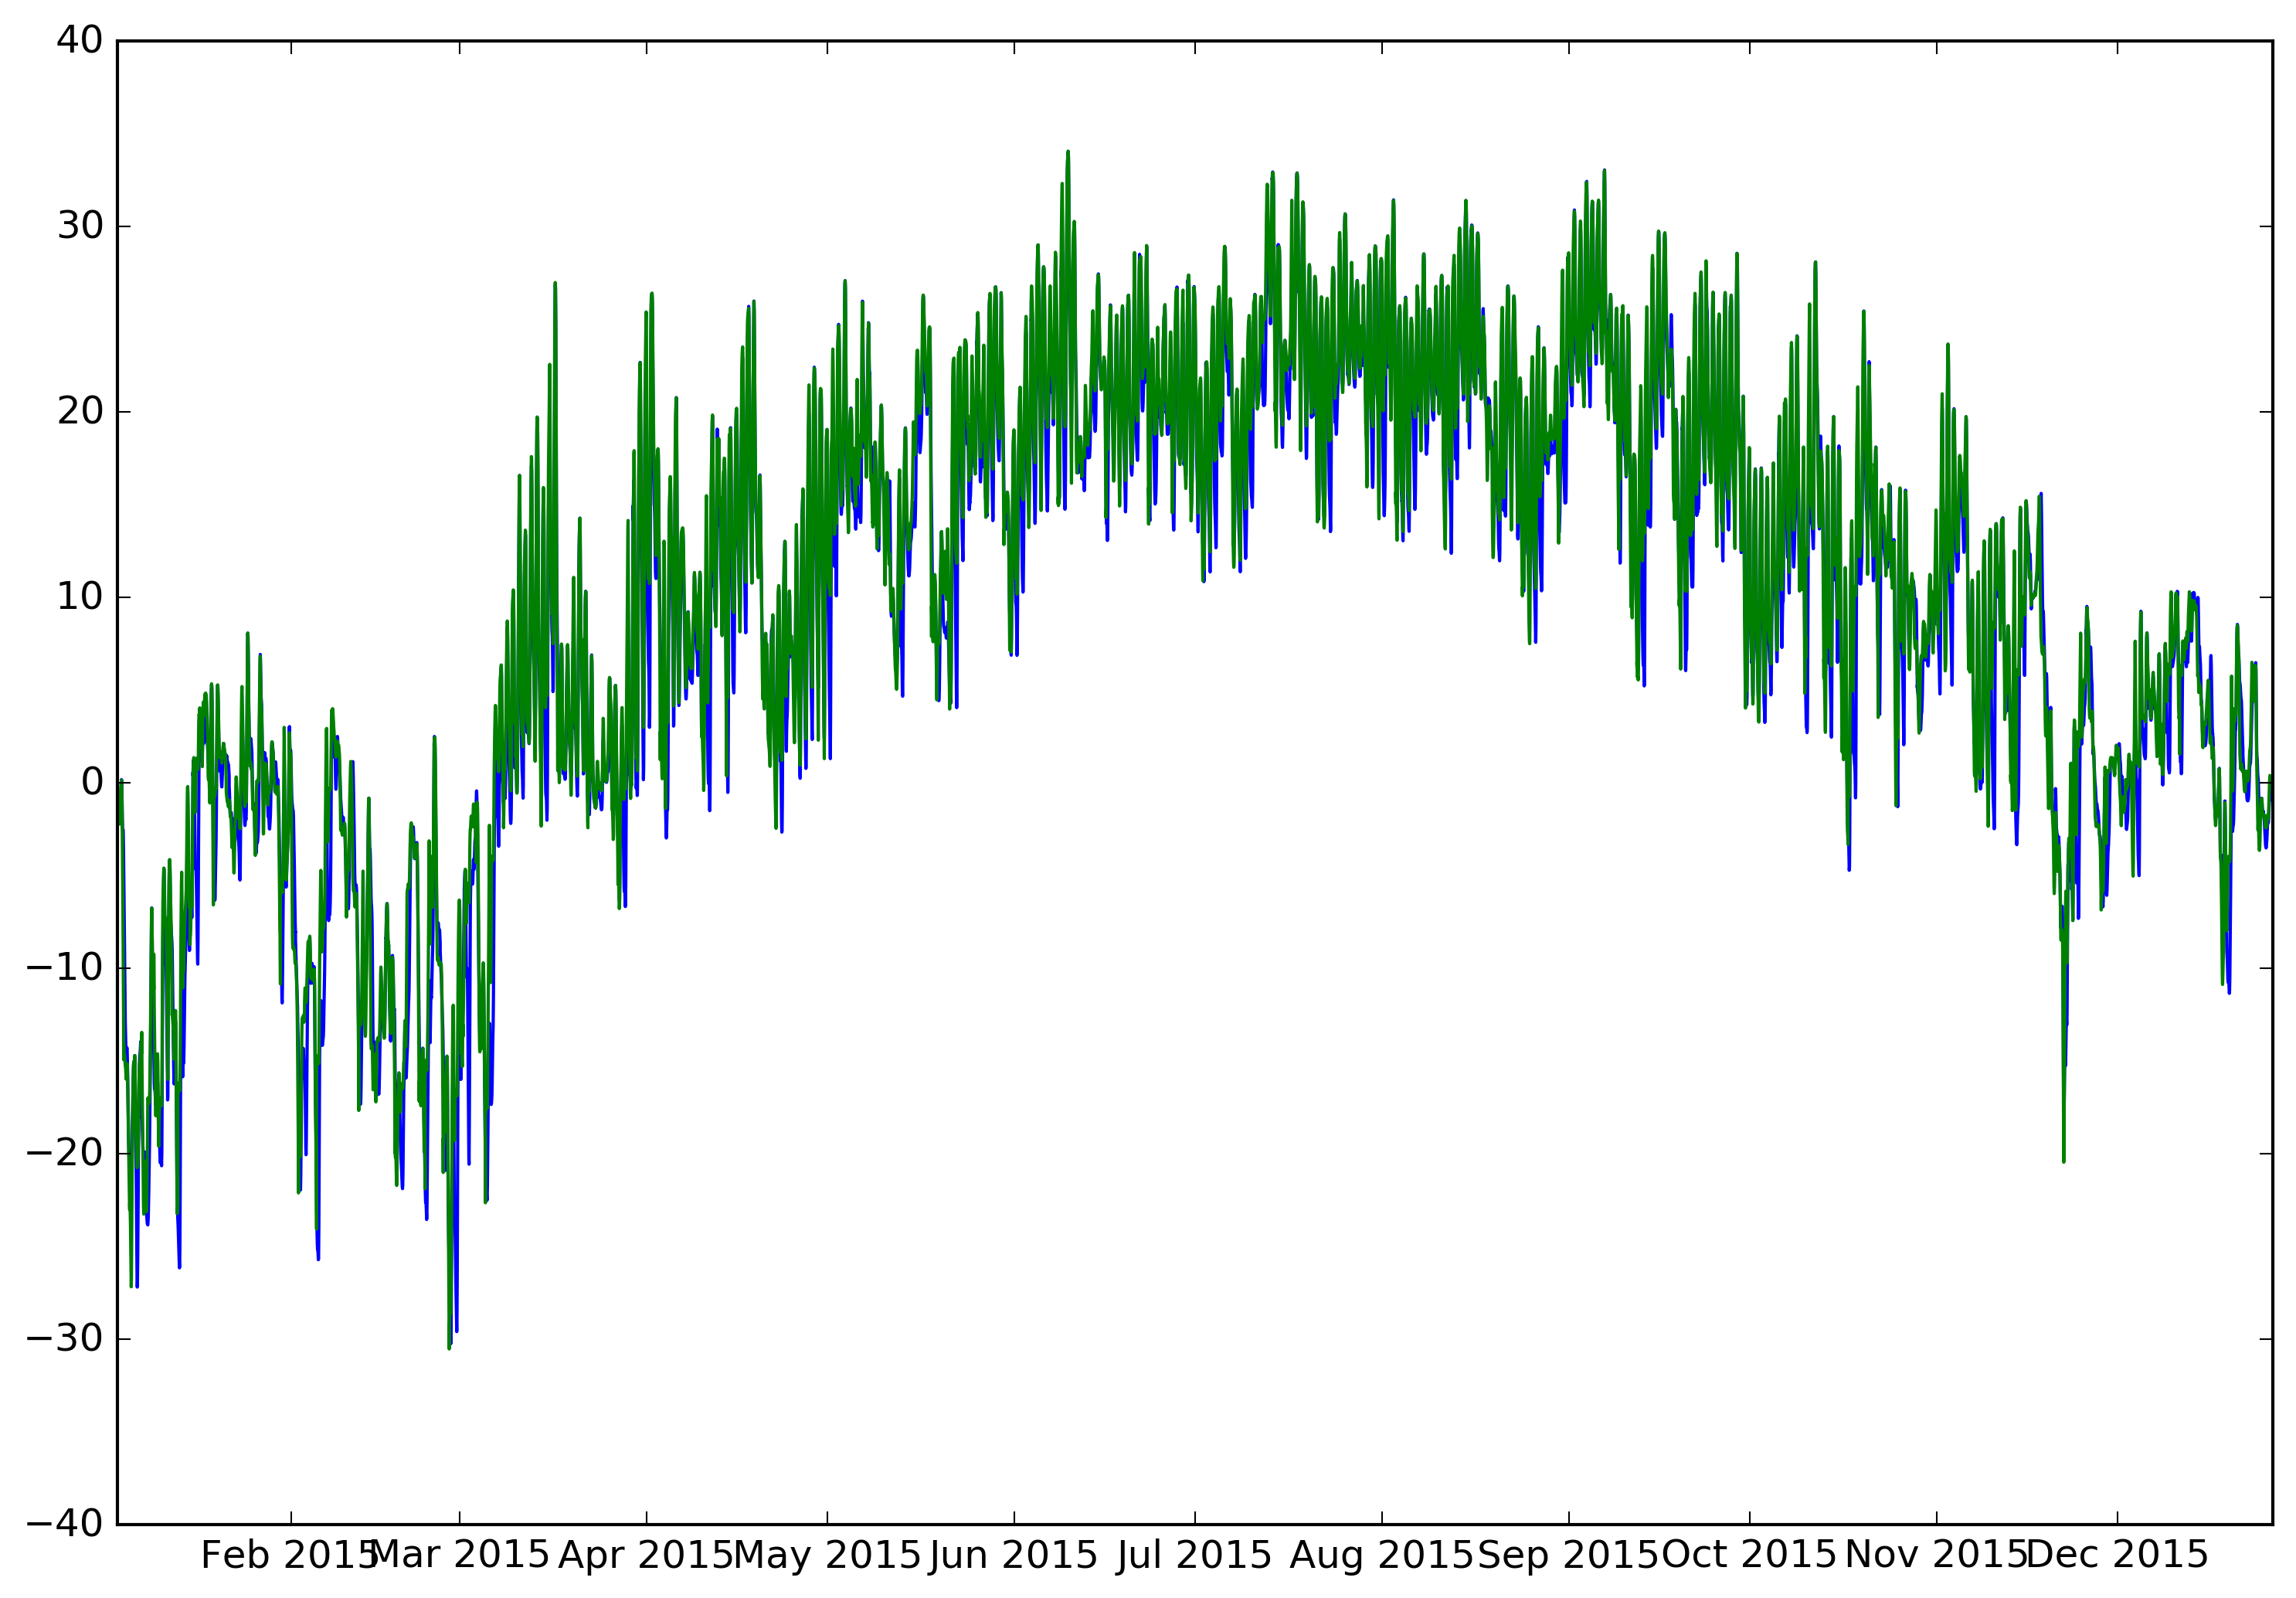

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x37ff0fbd0>

In [117]:
plt.plot(stitched_ts_dict[Hour(17)], stitched_mean_dict[Hour(17)])
plt.plot(stitched_ts_dict[Hour(5)], stitched_mean_dict[Hour(5)])

# Nearby Predictions

In [21]:
nearby_windows = [
    FittingWindow(Date(2015,1,1),Date(2015,3,14)),
    FittingWindow(Date(2015,1,25),Date(2015,4,8)),
    FittingWindow(Date(2015,2,18),Date(2015,5,2)),
    FittingWindow(Date(2015,3,14),Date(2015,5,26)),
    FittingWindow(Date(2015,4,8),Date(2015,6,20)),
    FittingWindow(Date(2015,5,2),Date(2015,7,14)),
    FittingWindow(Date(2015,5,26),Date(2015,8,7)),
    FittingWindow(Date(2015,6,20),Date(2015,9,1)),
    FittingWindow(Date(2015,7,14),Date(2015,9,25)),
    FittingWindow(Date(2015,8,7),Date(2015,10,19)),
    FittingWindow(Date(2015,9,1),Date(2015,11,13)),
    FittingWindow(Date(2015,9,25),Date(2015,12,7)),
    FittingWindow(Date(2015,10,19),Date(2015,12,31)),
]

13-element Array{FittingWindow,1}:
 FittingWindow(2015-01-01,2015-03-14)
 FittingWindow(2015-01-25,2015-04-08)
 FittingWindow(2015-02-18,2015-05-02)
 FittingWindow(2015-03-14,2015-05-26)
 FittingWindow(2015-04-08,2015-06-20)
 FittingWindow(2015-05-02,2015-07-14)
 FittingWindow(2015-05-26,2015-08-07)
 FittingWindow(2015-06-20,2015-09-01)
 FittingWindow(2015-07-14,2015-09-25)
 FittingWindow(2015-08-07,2015-10-19)
 FittingWindow(2015-09-01,2015-11-13)
 FittingWindow(2015-09-25,2015-12-07)
 FittingWindow(2015-10-19,2015-12-31)

In [22]:
""" 
    Is window A inside of window B?
"""
function a_isinside_b(t::DateTime, b::FittingWindow)
    start_after = t >= b.start_date
    end_before = t <= b.end_date+Day(1)
    return start_after & end_before
end
"""
    How much buffer time is there on either side of the window?
"""
function buffer(t::DateTime, b::FittingWindow)
    start_diff = abs(t - b.start_date)
    end_diff = abs(t - (b.end_date+Day(1)))
    return min(start_diff, end_diff)
end
""" 
    Amongst a list of candidate windows `cand`, find the window that includes `wind`
    with the largest buffer on either sides.
"""
function find_best_window(t::DateTime, cands::Vector{FittingWindow})
    incl_wdows = [fw for fw in cands if a_isinside_b(t, fw)]
    buffers = [buffer(t, fw) for fw in incl_wdows]
    imax = indmax(buffers)
    best_window = incl_wdows[imax]
    return best_window
end

find_best_window

In [23]:
all_nearby_preds = Dict{FittingWindow, TempModel.NearbyPrediction}()
GPmodel = "SExSE"
for fw in nearby_windows
    all_nearby_preds[fw] = get_nearby(fw, GPmodel)
end

In [33]:
stitched_nearby_mean = Float64[]
nearby_ts = hourly_test[:ts].values
best_pred_window = [find_best_window(t, nearby_windows) for t in nearby_ts]
for fw in nearby_windows
    local ts_start
    local ts_end
    try
        ts_start, ts_end = extrema(t for (i,t) in enumerate(nearby_ts) if best_pred_window[i] == fw)
    catch
        continue
    end
    nearby_pred = all_nearby_preds[fw]
    nrby_subset = argsubset(nearby_pred.ts, ts_start, ts_end, closed_start=true, closed_end=true)
    μ_window = nearby_pred.μ[nrby_subset]
    append!(stitched_nearby_mean, μ_window)
end

@assert length(nearby_ts) == length(stitched_nearby_mean)

In [74]:
hourly_test[:ts_day] = [TempModel.measurement_date(t, Hour(17)) for t in hourly_test[:ts].values]
TnTx = DataFrames.by(hourly_test, :ts_day, df -> DataFrame(
    Tn=minimum(df[:temp].values), 
    Tx=maximum(df[:temp].values)))
;

In [78]:
?plt.xticks


    Get or set the *x*-limits of the current tick locations and labels.

    ::

      # return locs, labels where locs is an array of tick locations and
      # labels is an array of tick labels.
      locs, labels = xticks()

      # set the locations of the xticks
      xticks( arange(6) )

      # set the locations and labels of the xticks
      xticks( arange(5), ('Tom', 'Dick', 'Harry', 'Sally', 'Sue') )

    The keyword args, if any, are :class:`~matplotlib.text.Text`
    properties. For example, to rotate long labels::

      xticks( arange(12), calendar.month_name[1:13], rotation=17 )
    

In [99]:
plt.matplotlib[:dates]

PyObject <module 'matplotlib.dates' from '/Users/imolk/bin/venv_jupyter/lib/python2.7/site-packages/matplotlib/dates.pyc'>

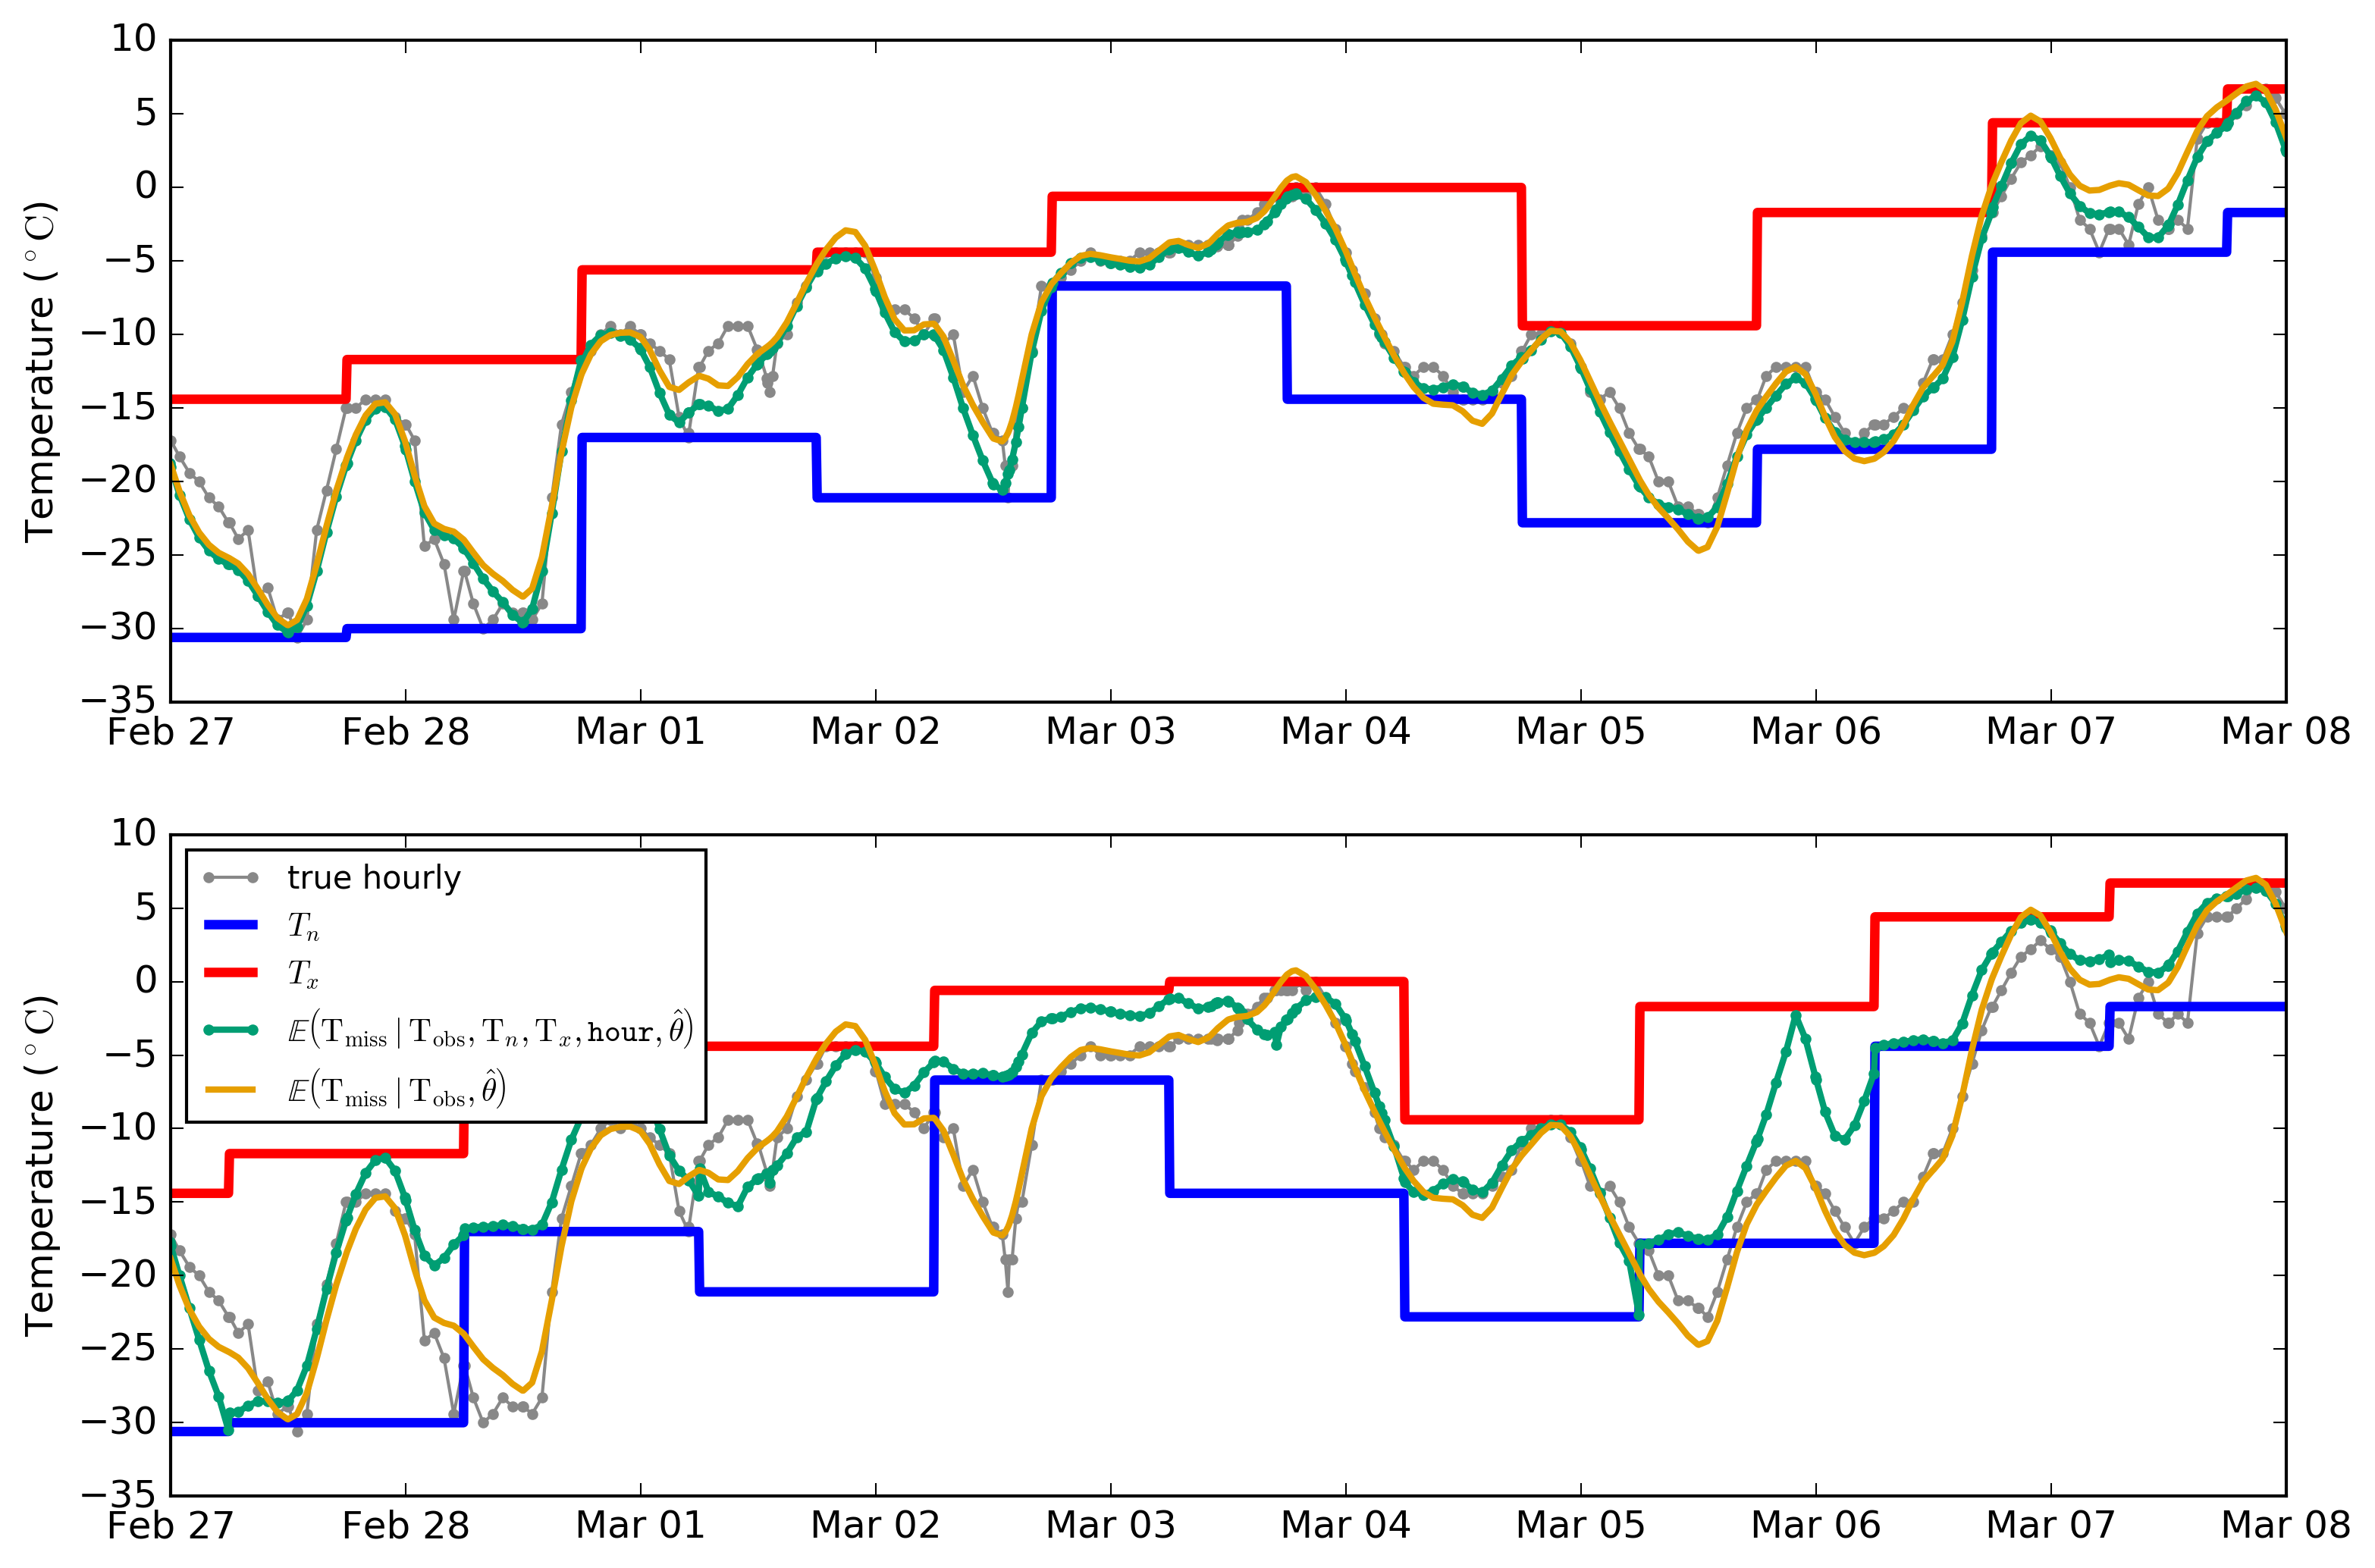

In [134]:
# xlim = [maximum(minimum(ts) for ts in values(stitched_ts_dict)),
#         minimum(maximum(ts) for ts in values(stitched_ts_dict))]
# xlim = [DateTime(2015,6,12,0,0,0), DateTime(2015,6,24,0,0,0)]
xlim = [DateTime(2015,2,27,0,0,0), DateTime(2015,3,8,0,0,0)]
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
for (ihr,hr) in enumerate((Hour(17),Hour(5)))
    plt.subplot(2,1,ihr)
    
    stitched_ts = stitched_ts_dict[hr]
    stitched_mean = stitched_mean_dict[hr]
    nearby_subset = argsubset(nearby_ts, xlim[1], xlim[2], closed_start=true, closed_end=true)
    nearby_ts_subset = nearby_ts[nearby_subset]
    
    hourly_test[:ts_day] = [TempModel.measurement_date(t, hr) for t in hourly_test[:ts].values]
    test_TnTx = join(hourly_test[nearby_subset,:], TnTx, on=:ts_day)
    truth_subset = test_TnTx[:temp].values
    
    plt.plot(nearby_ts_subset, truth_subset, 
        color="#888888", ".-", label="true hourly")
    plt.plot(nearby_ts_subset, test_TnTx[:Tn].values, 
        color="blue", linewidth=3, label=L"$T_n$")
    plt.plot(nearby_ts_subset, test_TnTx[:Tx].values, 
        color="red", linewidth=3, label=L"$T_x$")
    
    impute_subset = argsubset(stitched_ts, xlim[1], xlim[2], closed_start=true, closed_end=true)
    nearby_stitched_sub = stitched_nearby_mean[nearby_subset]
    nearby_stitched_sub .+= mean(truth_subset) .- mean(nearby_stitched_sub)
    plt.plot(stitched_ts, stitched_mean, ".-", 
        linewidth=2,color=cbbPalette[3],
        label=L"\mathbb{E}\left( \mathrm{T}_{\mathrm{miss}} \mid \mathrm{T}_{\mathrm{obs}}, \mathrm{T}_{n}, \mathrm{T}_{x}, \mathtt{hour}, \hat{\theta} \right)")
    plt.plot(nearby_ts_subset, nearby_stitched_sub, 
        color=cbbPalette[1], linewidth=2, 
        label=L"$\mathbb{E}\left( \mathrm{T}_{\mathrm{miss}} \mid \mathrm{T}_{\mathrm{obs}}, \hat{\theta} \right)$")
    plt.ylabel(L"Temperature (${}^\circ \mathrm{C}$)")
    plt.xlim(xlim)
    plt.ylim(-35,10)
    
    plt.gca()[:xaxis][:set_major_formatter](plt.matplotlib[:dates][:DateFormatter]("%b %d"))
end
plt.legend(loc="upper left", fontsize="small")
plt.savefig("figures/measure_hour_example.png")
plt.savefig("figures/measure_hour_example.pdf")